# Preparing FB movement data for fitting (updated on 28-04-2020)


_Akin Kazakci, Mines ParisTech - PSL University_

Input:
- movement_with_density_code_insee_'date'.csv
Output:
- 
    

The objective in this notebook is to build new features based on  Facebook Population and Density datasets. Essentially, these new features will be agregations of movement related quantities per department and per time slice.

The reason why we need to agregate these quantities at the department level is this: we currenly only have observations of Covid-19 incidences at the departmental level; thus in later notebooks we will build predictions at the departmental level. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib
import numpy as np

In [3]:
# movement_with_density_code_insee corresponds to the merge of movement and population density data.
moves = pd.read_csv('movement_with_density_code_insee_07-05-2020.csv', index_col = 0)

In [4]:
moves = moves[[ 'date_time', 
    'start_polygon_id', 'start_polygon_name', # keep those cause incoming traffic / graph 
    'end_polygon_id', 'end_polygon_name', 
    'length_km',  # size of polygon is an interesting feature a priori, or is this length of movement? even better
    'n_crisis', 'n_baseline', 'n_difference',
    'percent_change', 
    'date', #key
    'end_code_insee',  'start_code_insee',  #keys
    'end_density_crisis', 'end_density_baseline',
    'start_density_crisis',
    'start_density_baseline' ]]

In [5]:
# I will change the variable names 'n_crisis', 'n_baseline', 'n_difference','percent_change' to 'movement',
# 'movement_baseline','movement', 'movement_baseline','movement_difference', 'movement_percent_change'
       
moves.columns =  ['date_time', 'start_polygon_id', 'start_polygon_name', 'end_polygon_id',
       'end_polygon_name', 'length_km', 'movement', 'movement_baseline',
       'movement_difference', 'movement_percent_change', 'date', 'end_code_insee',
       'start_code_insee', 'end_density_crisis', 'end_density_baseline',
       'start_density_crisis', 'start_density_baseline']

In [6]:
moves['date_time'] = pd.to_datetime(moves['date_time'])

In [7]:
moves['time']=moves['date_time'].apply(lambda x: x.time())

In [8]:
# A feature I think will be useful is to weight the movement by density of the origin
# this is assuming that the denser a point is, the higher the chances it will bring infection to a destination
# alternative / complementary: use that days number of patients

moves['time']=moves['date_time'].apply(lambda x: x.time())
moves['density_weighted_movement'] = moves['movement'] * moves['start_density_crisis']

# Feature building strategy


for each dept, we can have 3 broad categories of features.
* *influx_to_dept* These features should capture incoming traffic to the department. The origin of the movement is outside of that dept.
* *intra_dept_flux* Intra-departmental traffic can have a large impact on the progagation of disease in that department, even thought influx or outflux is limited.
* outflux_from_dept* These feautres represent outgoing traffic. Assuming that, of those who leave will eventually return, this traffic _may_ have _some_ information related to disease traffic. 

In the current note, I will only focus on the first two.
All of the above categories can be _weighted_ according to the population density of the origin. The density of each department is also a factor to consider. Another _weighting_ factor might be the intra-traffic of the origine. 

In [9]:
#incoming = moves.groupby(['end_code_insee','date_time'])
intra =  moves[moves.end_code_insee == moves.start_code_insee]
non_intra =  moves[moves.end_code_insee != moves.start_code_insee]

For both groups, I build certain features and ignore others. The original Facebook data can be leveraged in many other ways to build features that I did not consider for the time being. One must be careful that this may have an effect on the final predictions.

# Features about intra-departemental movements

Some basic features I shall use for the time being:

- Node count: nbr of nodes in the subgraph
- Average indegree: mean of indegrees for the subgraph nodes only
- Total movement: sum of movement for the subgraph

The following shape shows that there are very few information in Facebook movement dataset regarding movement dynamics in a given city (department). Only ~400 lines over a 50 days period with ~95 departments. As we see in the EDA_intra notebook, basically this only provides features for Paris region - the only one with significant movement during lockdown.

In [16]:
intra.shape

(372, 19)

In [10]:
intra_feat = intra.groupby(['date_time','end_code_insee'])

In [11]:
intra_feat

In [12]:
# HOW MANY NODES ARE ACTIVE (APPEAR IN MOVEMENT EDGE) IN A DEPARTMENT GIVEN A TIME SLICE
appendable = []
for name, group in intra_feat:
    node_count = pd.Series(pd.Series(np.append(group.start_polygon_id.unique(),group.end_polygon_id.unique())).unique()).count()
    #print (node_count)
    appendable.append([name[0],name[1],node_count])
    #group['intra_node_count'] = node_count

In [13]:
intra_node_count_per_dept = pd.DataFrame(appendable, columns = ['date_time','code_insee', 'intra_node_count'])

In [14]:
# AVERAGE EDGE COUNT FOR ACTIVE NODES IN A DEPARTMENT GIVEN A TIME SLICE
appendable = []
for name, group in intra_feat:
    node_count = pd.Series(pd.Series(np.append(group.start_polygon_id.unique(),group.end_polygon_id.unique())).unique()).count()
    edge_count = group.shape[0]
    intra_mean_indegree = edge_count / node_count
    appendable.append([name[0],name[1],intra_mean_indegree])
    #group['intra_node_count'] = node_count

In [15]:
intra_mean_indegree = pd.DataFrame(appendable, columns = ['date_time','code_insee', 'intra_mean_indegree'])

In [16]:
# SUM OF MOVEMENT RELATED QUANTITIES IN A DEPARTMENT GIVEN A TIME SLICE
appendable = []
for name, group in intra_feat:
    df = group[['movement','movement_baseline','movement_difference','end_density_crisis','end_density_baseline','start_density_crisis','start_density_baseline','length_km','density_weighted_movement']].sum()
    alist = [name[0],name[1]]
    alit = alist.extend(df.values.tolist())
    #print (alist)
    
    appendable.append(alist)
   # print (name[0],name[1] , df.values)
    #group['intra_node_count'] = node_count

In [17]:
dept_cumulative_stats = pd.DataFrame(appendable, columns = ['date_time','code_insee','intra_move','intra_move_base','intra_move_diff','intra_end_density','intra_end_dens_base','intra_start_density','intra_start_dens_base',
                                                           'intra_length_km','intra_density_weighted_movement'])

## The result of the previous 3 steps are the following tables

In [24]:
dept_cumulative_stats.tail(3)

,date_time,code_insee,intra_move,intra_move_base,intra_move_diff,intra_end_density,intra_end_dens_base,intra_start_density,intra_start_dens_base,intra_length_km,intra_density_weighted_movement
183,2020-05-05 00:00:00,75,1789.0,7997.2,-6208.2,184408.0,222484.286581,184408.0,222484.286581,13.716194,164390960.0
184,2020-05-05 08:00:00,75,3046.0,19369.0,-16323.0,227623.0,320162.751106,227623.0,320162.751106,13.675034,346026317.0
185,2020-05-05 16:00:00,75,3799.0,23514.4,-19715.4,214283.0,275856.553040,214283.0,275856.553040,13.768178,409122379.0


where the variable names are same as in FB data, but I prefixed _intra__ since these are intra-departmental statistics. 

In [19]:
intra_mean_indegree.head(3)

,date_time,code_insee,intra_mean_indegree
0,2020-03-05 00:00:00,75,1.0
1,2020-03-05 08:00:00,75,1.0
2,2020-03-05 16:00:00,75,1.0


In [20]:
intra_node_count_per_dept.head(3)

,date_time,code_insee,intra_node_count
0,2020-03-05 00:00:00,75,2
1,2020-03-05 08:00:00,75,2
2,2020-03-05 16:00:00,75,2


In [27]:
intra_node_count_per_dept.code_insee.value_counts()

75    186
Name: code_insee, dtype: int64

In [23]:
df = dept_cumulative_stats
df = intra_node_count_per_dept
df = intra_mean_indegree
print(dept_cumulative_stats.shape,intra_node_count_per_dept.shape,intra_mean_indegree.shape)


(186, 11) (186, 3) (186, 3)


## Merging the previous three tables to obtain one table for all intra-departmental features.

In [30]:
intra_stats_per_dept = pd.merge(intra_mean_indegree,intra_node_count_per_dept, how='left', on= ['code_insee','date_time'])

In [31]:
intra_stats_per_dept = pd.merge(intra_stats_per_dept, dept_cumulative_stats, how = 'left', on= ['code_insee','date_time'])

In [33]:
intra_stats_per_dept.shape

(186, 13)

In [34]:
intra_stats_per_dept.date_time.unique().shape

(186,)

In [35]:
intra_stats_per_dept.columns

Index(['date_time', 'code_insee', 'intra_mean_indegree', 'intra_node_count',
       'intra_move', 'intra_move_base', 'intra_move_diff', 'intra_end_density',
       'intra_end_dens_base', 'intra_start_density', 'intra_start_dens_base',
       'intra_length_km', 'intra_density_weighted_movement'],
      dtype='object')

In [36]:
intra_stats_per_dept['date'] = pd.to_datetime(intra_stats_per_dept.date_time).apply(lambda x: x.date())
intra_stats_per_dept['time'] = pd.to_datetime(intra_stats_per_dept.date_time).apply(lambda x: x.time())
intra_stats_per_dept = intra_stats_per_dept.fillna(0)

In [37]:
intra_stats_per_dept.to_csv('intra_flux.csv')

# Features about inter-departemental movements

Here, we shall consider quantities that will affect an end polygon: that is, we will build quantities that represent incoming movement to an end polygon, assuming that these movements might be correlated to the Covid-19 propagation.

In [25]:
non_intra.shape

(50655, 19)

In [31]:
#incoming features; movements coming _to_ department
#this is an important cell: it basically is the fundamental feature building block of our pipeline
#there surely is some place to creativity here

influx_to_dept = non_intra.groupby(['end_code_insee', 'date_time'], as_index = False).agg( #'start_code_insee',
    {
        'length_km':'sum',  # sum of distance covered during moves
        'movement':'sum',   # total movement coming to department
        'movement_baseline':'sum', # total baseline movement coming to department - before the crisis happened
        'movement_difference':'sum',
        'movement_percent_change':'sum', # bad idea cause - and + compensate
        'density_weighted_movement':'sum'
    }
)
influx_to_dept.sort_values(['end_code_insee','date_time'], inplace=True)
influx_to_dept.rename(columns = {'end_code_insee':'code_insee'}, inplace= True)

In [42]:
influx_to_dept.shape

(14675, 8)

In [32]:
influx_to_dept.shape[0] / influx_to_dept.code_insee.unique().shape[0]

157.79569892473117

In [41]:
# we have 186 unique time steps (3/5 to 5/5 x 3 time slices)
influx_to_dept.date_time.unique().shape

(186,)

### Almost all departments are represented in almost all time steps in the influx_to dataframe. The Facebook movement dataset seems essentially to be useful when we consider inter-departmental movements.

76     186
72     186
14     186
69D    186
93     186
07     186
34     186
27     186
43     186
95     186
94     186
42     186
01     186
59     186
61     186
78     186
71     186
60     186
33     186
24     186
75     186
62     186
13     186
77     186
84     186
38     186
57     186
91     186
30     186
26     186
      ... 
46     157
18     156
50     151
88     148
11     146
45     146
41     145
63     142
32     140
37     140
47     139
55     131
03     128
89     128
65     126
53     124
12     122
52     120
04     118
79     114
36     113
86     104
09     101
08      99
66      67
05      65
87      63
23      37
15      18
48       7
Name: code_insee, Length: 93, dtype: int64

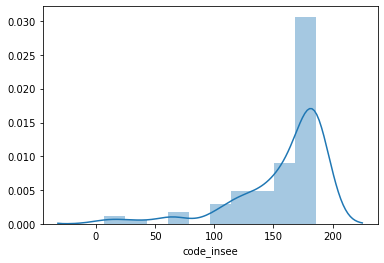

In [40]:
# almost all departments are represented in almost all time steps in the influx_to dataframe.
import seaborn as sns
sns.distplot(influx_to_dept.code_insee.value_counts())
influx_to_dept.code_insee.value_counts()

In [41]:
influx_to_dept['date'] = pd.to_datetime(influx_to_dept.date_time).apply(lambda x: x.date())
influx_to_dept['time'] = pd.to_datetime(influx_to_dept.date_time).apply(lambda x: x.time())
influx_to_dept = influx_to_dept.fillna(0)

In [43]:
influx_to_dept.to_csv('influx_to_dept_by_date.csv')

# Read & Prep Department based Covid-19 data

In [44]:
import pandas as pd
# Data from https://www.data.gouv.fr/en/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/
cases = pd.read_csv('donnees-hospitalieres-nouveaux-covid19-2020-05-06-19h00.csv', sep=';')

In [45]:
cases.head(3)

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,01,2020-03-19,1,0,0,0
1,01,2020-03-20,0,0,0,1
2,01,2020-03-21,4,0,0,0


In [46]:
cases.dep.unique().shape

(101,)

In [47]:
cases.shape

(4949, 6)

In [48]:
cases['c_incidence'] = cases['incid_hosp'].cumsum()
cases['c_reanim'] = cases['incid_rea'].cumsum()
cases['c_deces'] = cases['incid_dc'].cumsum()
cases['c_rad'] = cases['incid_rad'].cumsum()
cases.rename(columns={'jour':'date','dep':'code_insee'}, inplace=True)
cases['date'] = pd.to_datetime(cases.date).apply(lambda x: x.date())
cases.head(10)

,code_insee,date,incid_hosp,incid_rea,incid_dc,incid_rad,c_incidence,c_reanim,c_deces,c_rad
0,01,2020-03-19,1,0,0,0,1,0,0,0
1,01,2020-03-20,0,0,0,1,1,0,0,1
2,01,2020-03-21,4,0,0,0,5,0,0,1
3,01,2020-03-22,3,1,0,1,8,1,0,2
4,01,2020-03-23,14,1,0,5,22,2,0,7
5,01,2020-03-24,11,1,0,4,33,3,0,11
6,01,2020-03-25,13,2,0,5,46,5,0,16
7,01,2020-03-26,14,3,2,2,60,8,2,18
8,01,2020-03-27,14,2,0,0,74,10,2,18
9,01,2020-03-28,7,3,1,3,81,13,3,21


In [49]:
cases.date.unique().shape

(49,)

In [50]:
cases = cases.sort_values(by='date').reset_index()
cases.drop("index", inplace=True, axis=1)

In [51]:
cases.tail(10)

,code_insee,date,incid_hosp,incid_rea,incid_dc,incid_rad,c_incidence,c_reanim,c_deces,c_rad
4939,16,2020-05-06,0,0,0,1,10094,1473,1374,6087
4940,78,2020-05-06,16,0,2,13,70128,11955,11578,40771
4941,86,2020-05-06,0,0,1,1,73211,12478,12025,42663
4942,59,2020-05-06,33,6,16,64,36122,5900,5707,21085
4943,44,2020-05-06,6,0,1,9,23429,3767,3423,13879
4944,02,2020-05-06,20,1,1,18,1813,209,308,1096
4945,973,2020-05-06,0,0,0,0,99036,16333,16490,56192
4946,73,2020-05-06,1,0,1,1,53735,8725,8714,31348
4947,971,2020-05-06,0,0,0,0,98877,16302,16475,56074
4948,976,2020-05-06,8,1,1,6,99323,16361,16502,56421


In [63]:
cases_regrouped =  cases.groupby(['date'], as_index = False).agg({
    'incid_hosp':'sum',
    'incid_dc':'sum'
})
dates =cases_regrouped.date


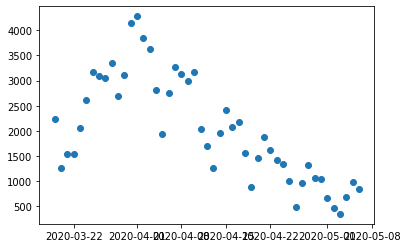

In [64]:
plt.yscale('linear')
plt.plot_date(dates, cases_regrouped[['incid_hosp']])#,'c_reanim','c_deces','c_rad']])
plt.show()

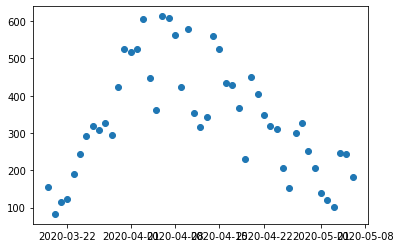

In [66]:
plt.plot_date(dates, cases_regrouped[['incid_dc']])
plt.show()

In [68]:
cases['date'] = pd.to_datetime(cases.date)
#cases.date..apply(lambda x: x.date())


In [69]:
cases.to_csv('incidence.csv')

# Merging daily Covid-19 case data with daily departmental movement data

In [423]:
data = pd.merge(cases, merged_by_date, how = 'outer', on = ['date','code_insee'])

In [437]:
data.head(10)

,code_insee,incid_hosp,incid_rea,incid_dc,incid_rad,c_incidence,c_reanim,c_deces,c_rad,intra_mean_indegree,intra_node_count,intra_move,intra_move_base,intra_move_diff,intra_end_density,intra_end_dens_base,intra_start_density,intra_start_dens_base,inter_dept_move_length,inter_dept_move,inter_dept_move_base,inter_dept_move_diff,inter_dept_move_percent_change
date,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.519737,54.0,4380.0,4808.0,-428.0,38160.0,37960.036955,25616.0,25898.950556,47.707669,49.0,46.8,2.2,11.194978
2020-03-04,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.718750,100.0,7249.0,6948.8,300.2,726263.0,698016.183414,338906.0,327346.118368,3278.285698,7711.0,7340.6,370.4,1484.661541
2020-03-04,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.773810,57.0,5050.0,4634.6,415.4,38170.0,37438.055283,41483.0,41174.906659,229.382215,189.0,179.6,9.4,92.148903
2020-03-04,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.356322,67.0,6031.0,5717.2,313.8,133814.0,127962.614949,138524.0,135322.264388,344.228425,721.0,719.4,1.6,-20.751485
2020-03-04,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.409958,92.0,6584.0,7415.0,-831.0,115535.0,117875.904730,73384.0,74546.771765,3003.550350,4314.0,4753.4,-439.4,-612.571051
2020-03-04,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.236538,119.0,30712.0,32001.4,-1289.4,247727.0,254606.877092,275723.0,283437.714556,1929.618295,1698.0,1637.8,60.2,356.440034
2020-03-04,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.792289,91.0,5940.0,5785.0,155.0,368875.0,355729.926330,231693.0,224571.314701,49.102262,56.0,55.4,0.6,20.531798
2020-03-04,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.176344,46.0,2131.0,2518.8,-387.8,375027.0,401365.457836,155150.0,165992.525788,131.462389,31.0,28.8,2.2,11.702128
2020-03-04,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.229324,126.0,9991.0,10570.6,-579.6,376307.0,392788.134101,364008.0,379317.025405,1086.906312,1094.0,1196.2,-102.2,-405.935030


In this (currently) final data table, the following columns are potential prediction targets:
- incid_hosp, incidence hospitalière, number of patients coming to the hospital (positives?)
- incid_rea, number of patients entering reanimation units (ICUs)	
- incid_dc, number of deceased	
- incid_rad, number of patients returning home	

The following are also potential prediction targets, that are cumulative versions of the previous variables
- c_incidence, 	
- c_reanim	
- c_deces	
- c_ra
    

In [436]:
data.set_index('date', inplace=True)

In [426]:
data = data.sort_values(by='date').reset_index()
data.drop("index", inplace=True, axis=1)

In [438]:
data.to_csv('data2.csv')